In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

import optuna

In [3]:
os.environ['OPENBLAS_NUM_THREADS'] = "1"

In [4]:
DATA_PATH = Path("../data")

In [93]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 2.69 s, sys: 212 ms, total: 2.9 s
Wall time: 3.2 s


In [94]:
Columns.Datetime = 'last_watch_dt'

# Preprocess Interactions

In [95]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [96]:
interactions.dtypes

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object

In [97]:
interactions.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

In [98]:
interactions[Columns.Datetime] = \
    pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [99]:
interactions.dropna(inplace=True)

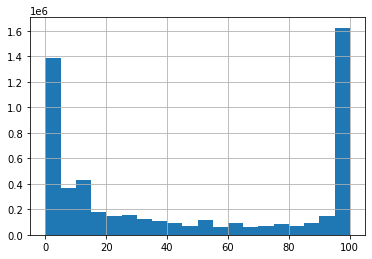

In [100]:
interactions['watched_pct'].hist(bins=20);

Делю график просмотра на 5 категорий, где:  
от 0% до 20%  = 1,  
от 21% до 40% = 2,  
... ,  
от 80% до 100% = 5

In [101]:
interactions[Columns.Weight] = np.where(interactions['watched_pct']
        > 20, 2, 1)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 40, 3,
                                  inplace=True)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 60, 4,
                                  inplace=True)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 80, 5,
                                  inplace=True)

<AxesSubplot:>

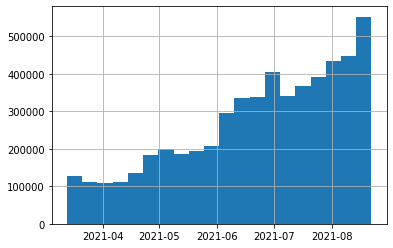

In [102]:
interactions[Columns.Datetime].hist(bins=20)

Вообще, видно, что кол-во пользователей растет

In [103]:
cold_users = \
    interactions[Columns.User].value_counts()[interactions[Columns.User].value_counts()
        == 1].index

<AxesSubplot:>

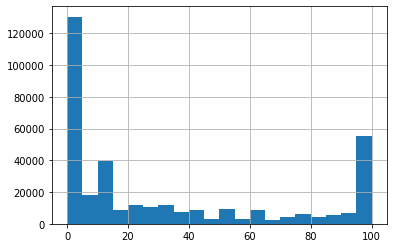

In [104]:
interactions[interactions[Columns.User].isin(cold_users)]['watched_pct'
        ].hist(bins=20)

Для холодных пользователей, я бы рекомендовал айтемы с самый высоким просмотром в среднем по холодным пользователям

In [105]:
cold_users = interactions[interactions[Columns.User].isin(cold_users)]
hot_users = interactions[~interactions[Columns.User].isin(cold_users)]
cold_users

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
10,791466,8199,2021-07-27,713,9.0,1
26,181144,10440,2021-08-08,27408,40.0,2
37,161176,10440,2021-07-29,22,0.0,1
38,21723,1819,2021-04-11,8535,100.0,5
60,77216,8143,2021-05-08,660,11.0,1
...,...,...,...,...,...,...
5476222,1007900,9728,2021-08-12,416,6.0,1
5476225,882138,4716,2021-05-21,1594,2.0,1
5476238,805174,13125,2021-06-27,1,0.0,1
5476246,648596,12225,2021-08-13,76,0.0,1


In [106]:
hot_users

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5
...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,1
5476247,546862,9673,2021-04-13,2308,49.0,3
5476248,697262,15297,2021-08-20,18307,63.0,4
5476249,384202,16197,2021-04-19,6203,100.0,5


In [107]:
cold_users['item_id'].value_counts().to_frame()

,item_id
10440,45695
15297,39309
2657,20474
9728,15140
4740,11455
...,...
1946,1
13886,1
14090,1
5730,1


In [108]:
cold_users[['item_id', 'total_dur']].groupby('item_id').mean().sort_values(by='total_dur', ascending=False).head(10).index

Int64Index([609, 4895, 3825, 5069, 14092, 12593, 7142, 2271, 13673, 11566], dtype='int64', name='item_id')

# Делим на train и test

In [109]:
max_date = interactions[Columns.Datetime].max()

In [110]:
train = interactions[interactions[Columns.Datetime] < max_date
                     - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date
                    - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4984443, 6)
test: (490980, 6)


In [111]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [112]:
drop_user = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(drop_user)].index, inplace=True)

# User preprocess

In [113]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [114]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

In [115]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
5,1037719,age_45_54,income_60_90,М,0
...,...,...,...,...,...
840184,529394,age_25_34,income_40_60,Ж,0
840186,80113,age_25_34,income_40_60,Ж,0
840188,312839,age_65_inf,income_60_90,Ж,0
840189,191349,age_45_54,income_40_60,М,1


Заменяю Nan'ы на Unknown

In [116]:
users.fillna('Unknown', inplace=True)

In [117]:
user_features_frames = []
for feature in ['sex', 'age', 'income']:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ['id', 'value']
    feature_frame['feature'] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


# Item preprocess

In [118]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [119]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [120]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

In [121]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       3775
release_year       31
genres              0
countries          14
for_kids        13415
age_rating          1
studios         13047
directors         939
actors           1858
description         0
keywords          388
dtype: int64

# Genre

In [122]:
# Explode genres to flatten table
items['genre'] = items['genres'].str.lower().str.replace(', ', ',',
        regex=False).str.split(',')
genre_feature = items[['item_id', 'genre']].explode('genre')
genre_feature.columns = ['id', 'value']
genre_feature['feature'] = 'genre'
genre_feature.head()


,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [123]:
genre_feature

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre


# Content

In [124]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type
...,...,...,...
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type


# Actors

In [125]:
items['actors'] = items['actors'].str.lower().str.replace(', ', ',',
        regex=False).str.split(',')
actors_feature = items[['item_id', 'actors']].explode('actors')
actors_feature.columns = ['id', 'value']
actors_feature['feature'] = 'actors'
actors_feature

,id,value,feature
0,10711,адольфо фернандес,actors
0,10711,ана фернандес,actors
0,10711,дарио грандинетти,actors
0,10711,джеральдин чаплин,actors
0,10711,елена анайя,actors
...,...,...,...
15961,4538,джудит родди,actors
15961,4538,марк о’халлоран,actors
15961,4538,джимми смоллхорн,actors
15962,3206,мкртыч арзуманян,actors


# Keywords

In [126]:
items['keywords'] = items['keywords'].str.lower().str.replace(', ', ','
        , regex=False).str.split(',')
keywords_feature = items[['item_id', 'keywords']].explode('keywords')
keywords_feature.columns = ['id', 'value']
keywords_feature['feature'] = 'keywords'
keywords_feature

,id,value,feature
0,10711,поговори,keywords
0,10711,ней,keywords
0,10711,2002,keywords
0,10711,испания,keywords
0,10711,друзья,keywords
...,...,...,...
15961,4538,2019,keywords
15961,4538,россия,keywords
15962,3206,гоша,keywords
15962,3206,2019,keywords


# Countries	

In [39]:
country_feature = items.reindex(columns=[Columns.Item, 'countries'])
country_feature.columns = ['id', 'value']
country_feature['feature'] = 'countries'
country_feature

,id,value,feature
0,10711,Испания,countries
1,2508,США,countries
2,10716,Канада,countries
3,7868,Великобритания,countries
4,16268,СССР,countries
...,...,...,...
15958,6443,"Финляндия, Германия",countries
15959,2367,Россия,countries
15960,10632,Россия,countries
15961,4538,Россия,countries


# Age Rating

In [40]:
age_feature = items.reindex(columns=[Columns.Item, "age_rating"])
age_feature.columns = ["id", "value"]
age_feature["feature"] = "age_feature"
age_feature

,id,value,feature
0,10711,16.0,age_feature
1,2508,16.0,age_feature
2,10716,16.0,age_feature
3,7868,16.0,age_feature
4,16268,12.0,age_feature
...,...,...,...
15958,6443,16.0,age_feature
15959,2367,18.0,age_feature
15960,10632,18.0,age_feature
15961,4538,18.0,age_feature


# Studios

In [41]:
items.fillna('Unknown', inplace=True)

In [42]:
studios_feature = items.reindex(columns=[Columns.Item, "studios"])
studios_feature.columns = ["id", "value"]
studios_feature["feature"] = "studios"
studios_feature

,id,value,feature
0,10711,Unknown,studios
1,2508,Unknown,studios
2,10716,Unknown,studios
3,7868,Unknown,studios
4,16268,Ленфильм,studios
...,...,...,...
15958,6443,Unknown,studios
15959,2367,Unknown,studios
15960,10632,Unknown,studios
15961,4538,Unknown,studios


In [128]:
# studios_feature, age_feature, country_feature - фичи которые хотелось бы использовать,
# но длительность обучения "OPTUNA" увеличивается в разы
item_features = pd.concat((genre_feature, content_feature ))
item_features

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type


# Metrics

In [129]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

In [130]:
TEST_USERS = test[Columns.User].unique()

# Optuna

In [131]:
NUM_THREADS = 8
RANDOM_STATE = 42
K = 5
NO_COMPONENTS = 32
N_EPOCHS = 1

In [132]:
USER_ALPHA = 0 
ITEM_ALPHA = 0 
K_RECOS = 10

In [54]:
dataset = Dataset.construct(interactions_df=train,
                            user_features_df=user_features,
                            cat_user_features=['sex', 'age', 'income'],
                            item_features_df=item_features,
                            cat_item_features=['content_type', 'genre'])
TEST_USERS = test[Columns.User].unique()


def objective(trial):
    model_name = trial.suggest_categorical('recomender', ['LightFM',
            'ALS'])
    if model_name == 'LightFM':
        learning_rate = trial.suggest_float('learning_rate', 1e-10, 1)
        k = trial.suggest_int('k', 2, 10)
        loss = trial.suggest_categorical('loss', ['logistic', 'bpr',
                'warp'])
        model = LightFMWrapperModel(LightFM(k=k,
                                    learning_rate=learning_rate,
                                    loss=loss, no_components=10),
                                    epochs=N_EPOCHS,
                                    num_threads=NUM_THREADS)
    else:
        regularization = trial.suggest_float('regularization', 1e-4,
                1e-2)
        model = \
            ImplicitALSWrapperModel(model=AlternatingLeastSquares(factors=10,
                                    random_state=RANDOM_STATE,
                                    num_threads=NUM_THREADS,
                                    regularization=regularization),
                                    fit_features_together=True)
    model.fit(dataset)
    recos = model.recommend(users=TEST_USERS, dataset=dataset,
                            k=K_RECOS, filter_viewed=True)
    metric = calc_metrics(metrics, recos, test, train)['MAP@10']
    print ('MAP@10', metric)
    return metric


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-12-12 18:32:01,241] A new study created in memory with name: no-name-d2c12238-d18d-4c6f-bca4-840e7d3f29b0
[I 2022-12-12 18:41:40,178] Trial 0 finished with value: 0.07156314077881751 and parameters: {'recomender': 'ALS', 'regularization': 0.0035671951579306937}. Best is trial 0 with value: 0.07156314077881751.


MAP@10 0.07156314077881751


[I 2022-12-12 18:51:48,671] Trial 1 finished with value: 0.07241639094290958 and parameters: {'recomender': 'ALS', 'regularization': 0.006724126527816994}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.07241639094290958


[I 2022-12-12 18:53:18,697] Trial 2 finished with value: 1.4050149479540313e-07 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.8190152272980945, 'k': 6, 'loss': 'bpr'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 1.4050149479540313e-07


[I 2022-12-12 18:54:36,340] Trial 3 finished with value: 0.005366068762176463 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.18723291153626603, 'k': 7, 'loss': 'bpr'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.005366068762176463


[I 2022-12-12 18:56:21,781] Trial 4 finished with value: 0.0002205827579874263 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.6560234930178588, 'k': 6, 'loss': 'logistic'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.0002205827579874263


[I 2022-12-12 19:05:46,138] Trial 5 finished with value: 0.07173988822226253 and parameters: {'recomender': 'ALS', 'regularization': 0.009044651486228098}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.07173988822226253


[I 2022-12-12 19:07:05,748] Trial 6 finished with value: 3.943062688880311e-06 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.44751878244334975, 'k': 7, 'loss': 'warp'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 3.943062688880311e-06


[I 2022-12-12 19:08:22,099] Trial 7 finished with value: 0.06793721324055035 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.10438302844592218, 'k': 3, 'loss': 'warp'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.06793721324055035


[I 2022-12-12 19:17:32,898] Trial 8 finished with value: 0.07184311920591484 and parameters: {'recomender': 'ALS', 'regularization': 0.0005806772800434514}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.07184311920591484


[I 2022-12-12 19:18:59,268] Trial 9 finished with value: 2.2409988419866796e-06 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.805131840226543, 'k': 7, 'loss': 'bpr'}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 2.2409988419866796e-06


[I 2022-12-12 19:28:09,202] Trial 10 finished with value: 0.07180954187357708 and parameters: {'recomender': 'ALS', 'regularization': 0.008190821633209066}. Best is trial 1 with value: 0.07241639094290958.


MAP@10 0.07180954187357708


[I 2022-12-12 19:37:15,147] Trial 11 finished with value: 0.07244222251339615 and parameters: {'recomender': 'ALS', 'regularization': 0.00026970098377155163}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07244222251339615


[I 2022-12-12 19:46:24,260] Trial 12 finished with value: 0.07202031081710311 and parameters: {'recomender': 'ALS', 'regularization': 0.0066363513358619185}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07202031081710311


[I 2022-12-12 19:55:34,176] Trial 13 finished with value: 0.07199398893026046 and parameters: {'recomender': 'ALS', 'regularization': 0.004156107607150058}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07199398893026046


[I 2022-12-12 20:04:42,589] Trial 14 finished with value: 0.07167963259586223 and parameters: {'recomender': 'ALS', 'regularization': 0.0006228566403390988}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07167963259586223


[I 2022-12-12 20:13:49,348] Trial 15 finished with value: 0.07202106855494453 and parameters: {'recomender': 'ALS', 'regularization': 0.00598705937836684}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07202106855494453


[I 2022-12-12 20:22:57,770] Trial 16 finished with value: 0.07193963920172777 and parameters: {'recomender': 'ALS', 'regularization': 0.0028834604694796696}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07193963920172777


[I 2022-12-12 20:32:04,614] Trial 17 finished with value: 0.07186249836889418 and parameters: {'recomender': 'ALS', 'regularization': 0.007249626991281137}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07186249836889418


[I 2022-12-12 20:41:24,258] Trial 18 finished with value: 0.07164870366757094 and parameters: {'recomender': 'ALS', 'regularization': 0.005115162467576984}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07164870366757094


[I 2022-12-12 20:50:49,059] Trial 19 finished with value: 0.07179004415938793 and parameters: {'recomender': 'ALS', 'regularization': 0.0018963762834092678}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07179004415938793


[I 2022-12-12 21:42:16,853] Trial 20 finished with value: 0.07167129296212232 and parameters: {'recomender': 'ALS', 'regularization': 0.009804091535656343}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07167129296212232


[I 2022-12-12 21:52:20,413] Trial 21 finished with value: 0.07191839766465505 and parameters: {'recomender': 'ALS', 'regularization': 0.005764203522687446}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07191839766465505


[I 2022-12-12 22:02:12,773] Trial 22 finished with value: 0.07159025974450188 and parameters: {'recomender': 'ALS', 'regularization': 0.006209360331833826}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07159025974450188


[I 2022-12-12 22:12:55,936] Trial 23 finished with value: 0.07167021208897958 and parameters: {'recomender': 'ALS', 'regularization': 0.007825089420401029}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07167021208897958


[I 2022-12-12 22:23:04,762] Trial 24 finished with value: 0.07191850988173716 and parameters: {'recomender': 'ALS', 'regularization': 0.004979324924695012}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07191850988173716


[I 2022-12-12 22:34:38,654] Trial 25 finished with value: 0.07178449755342503 and parameters: {'recomender': 'ALS', 'regularization': 0.002381286135370409}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07178449755342503


[I 2022-12-12 22:45:43,850] Trial 26 finished with value: 0.07177449403191542 and parameters: {'recomender': 'ALS', 'regularization': 0.004677821831829}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07177449403191542


[I 2022-12-12 22:56:45,636] Trial 27 finished with value: 0.07214439856613958 and parameters: {'recomender': 'ALS', 'regularization': 0.0069504676367203744}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07214439856613958


[I 2022-12-12 23:08:13,361] Trial 28 finished with value: 0.07237690498752612 and parameters: {'recomender': 'ALS', 'regularization': 0.0074561399301387955}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07237690498752612


[I 2022-12-12 23:18:05,878] Trial 29 finished with value: 0.07173589378156864 and parameters: {'recomender': 'ALS', 'regularization': 0.00848249465326267}. Best is trial 11 with value: 0.07244222251339615.


MAP@10 0.07173589378156864


[W 2022-12-12 23:27:26,180] Trial 30 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_5286/352742220.py", line 40, in objective
    recos = model.recommend(
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/base.py", line 132, in recommend
    reco_user_ids, reco_item_ids, reco_scores = self._recommend_u2i(
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/vector.py", line 141, in _recommend_u2i
    scores = scores_calculator.calc(target_id)
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/vector.py", line 98, in calc
    scores = self.objects_factors @ subject_factors
KeyboardInterrupt


KeyboardInterrupt: 

## Пришлось остановить обучение, тк эти 30 эпох обучались 6 часов

In [55]:
study.best_params

{'recomender': 'ALS', 'regularization': 0.00026970098377155163}

In [133]:
# обучаем best model после optuna
model = \
    ImplicitALSWrapperModel(model=AlternatingLeastSquares(factors=32,
                            random_state=RANDOM_STATE,
                            num_threads=NUM_THREADS,
                            regularization=study.best_params['regularization'
                            ]), fit_features_together=True)

In [ ]:
model.fit(dataset)

In [58]:
recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True)

In [59]:
calc_metrics(metrics, recos, test, train)['MAP@10']

0.07124010116092815

In [61]:
recos = recos[['user_id', 'item_id']]
recos.to_csv('ALS_after_optuna.csv.gz', index=False, compression='gzip')

 ## Воспользоваться методом приближенного поиска соседей для выдачи рекомендаций. 

In [216]:
#pip install --no-binary :all: nmslib

In [62]:
import nmslib
import time

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [67]:
LEARNING_RATE = 0.08165160206425184
LOSS = 'warp'

In [68]:
# обучаем LightFM, чтобы достать из нее вектора пользователей и айтемов
model = LightFMWrapperModel(
    LightFM(
        k=K,
        no_components=NO_COMPONENTS, 
        loss= LOSS, 
        random_state=RANDOM_STATE,
        learning_rate=LEARNING_RATE,
        user_alpha=USER_ALPHA,
        item_alpha=ITEM_ALPHA),
    epochs=N_EPOCHS,
    num_threads=NUM_THREADS) 

In [69]:
model.fit(dataset)

In [72]:
user_embeddings, item_embeddings = model.get_vectors(dataset)

In [73]:
user_embeddings.shape, item_embeddings.shape

((756545, 34), (13963, 34))

In [74]:
#пользователь со средним значением по каждому признаку
first_person = user_embeddings.mean(0)
first_person

array([-2.48910075e+02,  1.00000000e+00, -3.04745167e-01,  1.30259299e-01,
       -1.25937782e-01,  1.32810516e-01, -3.98682870e-01,  2.12211904e-01,
        3.15063161e-01,  9.48599975e-03,  1.79876286e-01, -1.15210674e-01,
        3.13044085e-01,  5.25500635e-02, -8.94866249e-02,  6.32450803e-02,
        3.30464664e-01, -2.79290127e-01,  7.66675368e-02,  2.69704125e-01,
       -2.02872234e-01,  3.65543869e-02, -2.08750917e-01, -7.48397237e-02,
        2.09714412e-01,  1.28161004e-01, -2.49842146e-01,  7.57336145e-02,
        6.74582969e-02,  2.03054725e-01, -4.46441335e-02,  1.00222239e-01,
        3.09746759e-01,  2.26963989e-01])

In [75]:
#пользователь со минимальным значением по каждому признаку
second_person = user_embeddings.min(axis=0)
second_person

array([-364.41271973,    1.        ,   -2.19337273,   -2.05960441,
         -3.03305483,   -2.15237951,   -3.10027146,   -1.44008625,
         -1.55592728,   -1.69499218,   -1.87335801,   -3.19125104,
         -1.8664068 ,   -2.62357092,   -2.23808742,   -1.78050435,
         -1.67308342,   -2.70261121,   -1.94637215,   -2.44766903,
         -2.40233946,   -1.93648934,   -2.32535124,   -2.73280096,
         -2.20278382,   -1.93085539,   -2.29366779,   -1.9847883 ,
         -2.619452  ,   -1.8447926 ,   -2.03915739,   -1.86472845,
         -1.80441463,   -1.98137343])

In [76]:
#пользователь со максимальным значением по каждому признаку
third_person = user_embeddings.max(axis=0)
third_person

array([0.        , 1.        , 1.80414879, 2.91568851, 2.57092023,
       2.49563074, 3.0165813 , 2.02071786, 2.10402703, 1.86775827,
       1.81193578, 2.3456769 , 2.37611055, 4.0926795 , 1.8776809 ,
       1.91333187, 2.16625547, 1.76979506, 1.87265527, 2.63360167,
       1.97114313, 1.88249838, 1.89424872, 2.15507913, 2.38049865,
       1.99921763, 1.80478072, 1.8311218 , 3.32906055, 2.25318193,
       2.0245254 , 2.37490654, 2.28989363, 1.97282732])

In [77]:
user_embeddings.shape

(756545, 34)

In [78]:
# добавим векотра 3х новых пользователей
user_embeddings = np.append(user_embeddings, np.array([first_person,
                            second_person, third_person]), axis=0)
user_embeddings.shape


(756548, 34)

In [79]:
M = 50
efC = 150

num_threads = 8
chunkIndexSize = 10000

index_time_params = {
    'M': M,
    'indexThreadQty': num_threads,
    'efConstruction': efC,
    'post': 0,
    'chunkIndexSize': chunkIndexSize,
    }
print ('Index-time parameters', index_time_params)

Index-time parameters {'M': 50, 'indexThreadQty': 8, 'efConstruction': 150, 'post': 0, 'chunkIndexSize': 10000}


In [80]:
K = 10
space_name = 'negdotprod'
index = nmslib.init(method='hnsw', space=space_name,
                    data_type=nmslib.DataType.DENSE_VECTOR)
index.addDataPointBatch(item_embeddings)

13963

In [81]:
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads,
                     'efConstruction': efC}
index.createIndex(index_time_params)
end = time.time()
print ('Index-time parameters', index_time_params)
print 'Indexing time = %f' % (end - start)

Index-time parameters {'M': 50, 'indexThreadQty': 8, 'efConstruction': 150}
Indexing time = 1.392440


In [82]:
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

Setting query-time parameters {'efSearch': 100}


In [83]:
query_matrix = user_embeddings

In [84]:
query_qty = query_matrix.shape[0]
start = time.time()
nbrs = index.knnQueryBatch(query_matrix, k=K, num_threads=num_threads)
end = time.time()
print 'kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' \
    % (end - start, float(end - start) / query_qty, num_threads
       * float(end - start) / query_qty)


kNN time total=3.962551 (sec), per query=0.000005 (sec), per query adjusted for thread number=0.000042 (sec)


In [85]:
nbrs

[(array([ 32,  19,  43,  62, 449, 279, 305,  31,  36,  69], dtype=int32),
  array([313.13745, 313.2156 , 313.23563, 313.69226, 313.96838, 314.01437,
         314.05713, 314.0591 , 314.07086, 314.1464 ], dtype=float32)),
 (array([ 31, 262,  62, 149,   8, 450,  19,  32, 121, 735], dtype=int32),
  array([312.03275, 312.2426 , 312.44092, 312.47754, 312.50558, 312.55057,
         312.5966 , 312.61896, 312.65695, 312.85553], dtype=float32)),
 (array([ 19,  31, 121,  32, 173, 268,  43,  29,  62, 105], dtype=int32),
  array([292.56287, 292.7267 , 293.37714, 293.398  , 293.52377, 293.58594,
         293.59534, 293.6454 , 293.80536, 293.9107 ], dtype=float32)),
 (array([ 31,  19,  62, 121,  43,  32, 173, 268, 103, 105], dtype=int32),
  array([345.13394, 345.63568, 345.96344, 346.01605, 346.06268, 346.1905 ,
         346.40475, 346.4218 , 346.5124 , 346.5745 ], dtype=float32)),
 (array([ 43,  19,  32,  31,  62,  36, 449, 279, 121, 206], dtype=int32),
  array([-17.293152, -17.268269, -17.04797 , -

In [86]:
# рекомендации для всех пользователей 
recos_old_persons = np.array(nbrs, dtype=int)[:,0][:len(nbrs) - 3]
recos_old_persons

array([[ 32,  19,  43, ...,  31,  36,  69],
       [ 31, 262,  62, ...,  32, 121, 735],
       [ 19,  31, 121, ...,  29,  62, 105],
       ...,
       [ 31,  19,  43, ..., 268, 100,  86],
       [ 19,  31,  32, ..., 268,  49, 173],
       [ 19,  31,  32, ..., 100, 105, 268]])

In [87]:
# рекомендации для добавленных пользователей 
recos_new_persons =  np.array(nbrs, dtype=int)[:,0][-3:]
recos_new_persons

array([[   31,    19,    32,    43,    62,   121,   173,   268,   100,
           86],
       [12018, 10998,  7308, 12006, 10159, 10215,  3543,  8118,  8180,
        11511],
       [ 8453,  6400,  3557,  3945,  6642,  4779,  3583,  2068,  8668,
          371]])

In [88]:
df_r = \
    pd.DataFrame({'user_id': np.repeat(np.arange(len(recos_old_persons)),
                 10), Columns.Item: recos_old_persons.ravel()})
df_r


,user_id,item_id
0,0,32
1,0,19
2,0,43
3,0,62
4,0,449
...,...,...
7565445,756544,43
7565446,756544,29
7565447,756544,100
7565448,756544,105


In [89]:
df_r.to_csv('nmslib.csv.gz', index=False, compression='gzip')